# Lecture 3: Multi-Layer Perceptrons

In this lecture, we will introduce Multi-Layer Perceptrons (MLP).

We will reproduce the following paper [A Neural Probabilistic Language Model](https://jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)

## Curse of Dimensionality

For a character-level language model, the input vector is a one-hot vector of size 27 (26 characters + 1 space).

If the model is not a character-level language model, (e.g., word-level language model), the input vector size is the size of the vocabulary which is usually very large (e.g., 20,000).

This leads to the curse of dimensionality.

**Solution**: Use a lower-dimensional representation of the input vector.

The hypothesis is that similar words will have similar representations (e.g., dog and cat). Let's find a way to embed words into a lower-dimensional space.

**Example**
- The cat is walking in the bedroom. (Train data)
- A dog was running in a room. (Train data)
- The cat was running in a room. (Train data)
- A dog is walking in a bedroom. (Train data)
- A cat was running in a <?> (Test data)

The model should be able to predict the word "room"(or the similar words) in the test data.

## MLP

In the previous lecture, we have successfully implemented Bigram language model. 
In this lecture, we will implement a Multi-Layer Perceptron (MLP) language model.

For practical reasons, let's use a character-level language model.

![MLP](../images/MLP.png)

### Importing Libraries

In [1]:
import os
import matplotlib.pyplot as plt
import torch
from torch.nn import functional as F
from dataclasses import dataclass
from src.utils import load_text, set_seed
%matplotlib inline

### Configuration

In [2]:
@dataclass
class MLPConfig:
    root_dir: str = os.getcwd() + "/../../"
    dataset_path: str = "data/raw/names.txt"

    # Tokenizer
    vocab_size: int = 0  # Set later
    
    # Model
    context_size: int = 3
    d_embed: int = 16
    d_hidden: int = 64
    
    # Training
    batch_size: int = 32
    lr: float = 2e-4
    max_steps: int = 10000

    seed: int = 101

### Reproducibility

In [3]:
set_seed(MLPConfig.seed)
generator = torch.Generator().manual_seed(MLPConfig.seed)

Random seed set to 101


### Dataset

In [4]:
# Load text and split by lines
names = load_text(MLPConfig.root_dir + MLPConfig.dataset_path).splitlines()

Loaded text data from /mnt/c/Users/cheir/GitHub/LLM101/notebooks/Lectures/../../data/raw/names.txt (length: 228145 characters).


### Tokenizer

In [5]:
chars = [chr(i) for i in range(97, 123)]  # all alphabet characters
chars.insert(0, ".")  # Add special token
MLPConfig.vocab_size = len(chars)
str2idx = {char: idx for idx, char in enumerate(chars)}
idx2str = {idx: char for char, idx in str2idx.items()}

### Preprocessing

We need to create a dataset of (Input, Target) pairs.
- Input: current 3 characters
- Output: next 1 character

In [6]:
def get_dataloader(names):
    context_size = MLPConfig.context_size  # How many characters do we take to predict the next character
    xs, ys = [], []

    for name in names:
        #print(name)
        context = [0] * context_size
        
        for char in name + ".":
            idx = str2idx[char]
            xs.append(context)
            ys.append(idx)
            #print(''.join(idx2str[i] for i in context), '--->', idx2str[idx])
            context = context[1:] + [idx]  # Shift the context by 1 character
        
        #print("="*10)

    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    
    return xs, ys

In [7]:
xs_3, ys_3 = get_dataloader(names[:3])

print(f"Input shape: {xs_3.shape}, Output shape: {ys_3.shape}")

Input shape: torch.Size([16, 3]), Output shape: torch.Size([16])


In [8]:
xs, ys = get_dataloader(names)

print(f"Input shape: {xs.shape}, Output shape: {ys.shape}")
print(f"Input: {xs[0]}, Output: {ys[0]}")

Input shape: torch.Size([228146, 3]), Output shape: torch.Size([228146])
Input: tensor([0, 0, 0]), Output: 5


### Model

In [9]:
C = torch.randn(27, 2)

In [10]:
C.shape

torch.Size([27, 2])

In [11]:
# Embedding example
# a: [1, :]
a_embed = C[1, :]
print(f"Embedding of 'a': {a_embed}")

Embedding of 'a': tensor([-0.4323,  1.8811])


How Forward Pass works in MLP:
1. Embed the input characters.
2. Concatenate the embeddings.
3. Pass the concatenated embeddings through a hidden layer.
4. Pass the hidden layer output through an output layer.
5. Get the output of shape (vocab_size=27).


Don't know how to concatenate? PyTorch provides concatenation functionality. [PyTorch Documentation](https://pytorch.org/docs/stable/generated/torch.cat.html)

In [12]:
# Example forward pass
# Input: "emm"
e_embed = C[5]  # e: (embedding_size=2)
m_embed = C[12]
m_embed2 = C[12]

# Concatenate
# ------------------
# Write your implementation here.
x = torch.cat([e_embed, m_embed, m_embed2])  # (embedding_size*context_size=6)
# ------------------

# Hidden layer
# ------------------
# Write your implementation here.
W1 = torch.randn(6, 4)  # (6, hidden_size=4)
h = F.tanh(x @ W1)  # (hidden_size=4)
# ------------------

# Output layer
# ------------------
# Write your implementation here.
W2 = torch.randn(4, 27)  # (hidden_size=4, vocab_size=27)
y = F.softmax(h @ W2, dim=-1)  # (vocab_size=27)
# ------------------

print(f"Output shape: {y.shape}")
print(f"Output: {y}")

Output shape: torch.Size([27])
Output: tensor([0.1801, 0.0544, 0.0071, 0.0016, 0.2292, 0.0032, 0.0016, 0.0955, 0.0666,
        0.0019, 0.0169, 0.0164, 0.0696, 0.0032, 0.0114, 0.0086, 0.0209, 0.0091,
        0.0010, 0.0071, 0.0336, 0.0057, 0.0936, 0.0059, 0.0071, 0.0474, 0.0015])


Let's refactor the code

- Input:
    - Shape: (batch_size, context_size)
    - Example: [[5, 12, 12], [12, 12, 5]]  # "emm", "mme"

- Parameters:
    - Embedding:
        - Shape: (vocab_size, d_embed)
    - W1:
        - Shape: (d_embed * context_size, d_hidden)
    - W2:
        - Shape: (d_hidden, vocab_size)

- Output:
    - Shape: (batch_size, vocab_size)
    - Example: [[0.04, 0.03, ..., 0.02], [0.02, 0.03, ..., 0.04]]

In [13]:
# Initialize parameters
vocab_size = MLPConfig.vocab_size
context_size = MLPConfig.context_size
d_embed = MLPConfig.d_embed
d_hidden = MLPConfig.d_hidden
C = torch.randn(vocab_size, d_embed, generator=generator)
W1 = torch.randn(d_embed * context_size, d_hidden, generator=generator)
b1 = torch.randn(d_hidden, generator=generator)
W2 = torch.randn(d_hidden, vocab_size, generator=generator)
b2 = torch.randn(vocab_size, generator=generator)

parameters = [C, W1, b1, W2, b2]
for params in parameters:
    params.requires_grad = True
print(f"Number of parameters: {sum(p.numel() for p in parameters)}")

Number of parameters: 5323


### Training

PyTorch provides a CrossEntropyLoss function. [PyTorch Documentation](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)

**Note**: Softmax is already included in the CrossEntropyLoss function.

Change the learning rate so that the loss graph looks as following

![Loss](../images/loss.png)

x: tensor([[ 0,  0, 10],
        [ 0,  1, 18],
        [ 0,  0,  1],
        [ 9, 19,  8],
        [ 9, 18, 15],
        [ 9, 12, 15],
        [ 0,  0, 12],
        [ 0,  0, 26],
        [ 5, 25, 18],
        [ 5, 13,  1],
        [23,  1,  1],
        [ 0,  0, 20],
        [ 9, 12, 25],
        [ 1, 25, 12],
        [13,  1, 26],
        [ 0,  0,  0],
        [ 0,  1,  9],
        [ 0,  0,  1],
        [ 0,  0, 12],
        [ 0,  0,  0],
        [ 0, 20,  5],
        [ 0,  2, 18],
        [ 9, 19,  8],
        [ 0,  0, 13],
        [ 0,  0,  6],
        [26,  1, 14],
        [20,  5, 19],
        [ 8,  1, 18],
        [ 0,  4, 18],
        [18,  1,  8],
        [26,  9,  5],
        [ 0, 20,  1]])
y: tensor([21,  9, 16,  0,  0,  0, 12,  5,  0, 18, 12,  1,  5,  1, 25, 10, 11, 26,
         1, 10,  1,  9,  1,  1, 18,  5,  0, 20,  9,  0, 12, 13])


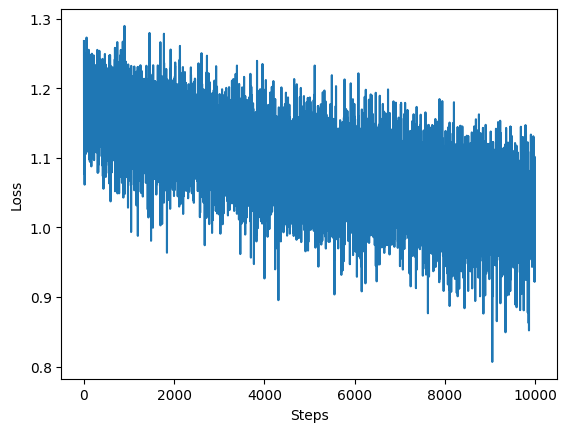

In [14]:
batch_size = MLPConfig.batch_size  # Do not change
max_steps = MLPConfig.max_steps  # Do not change
lr = MLPConfig.lr  # Change learning rate
steps = []
losses = []


for i in range(max_steps):
    # Mini-batch
    idx = torch.randint(0, len(xs), (batch_size,))
    x = xs[idx]  # (batch_size, context_size)
    y = ys[idx]  # (batch_size)
    if i == 0:
        print(f"x: {x}")
        print(f"y: {y}")
    
    # Forward pass
    # ------------------
    # Write your implementation here.
    ## Embedding
    x_embed = C[x]  # (batch_size, context_size, d_embed)
    ## Concatenate
    x = x_embed.view(batch_size, -1)  # (batch_size, d_embed*context_size)
    ## Hidden layer
    h = F.tanh(x @ W1 + b1)  # (batch_size, d_hidden)
    ## Output layer
    logits = h @ W2 + b2  # (batch_size, vocab_size)
    # ----------------
    loss = F.cross_entropy(logits, y)
    
    # Backward pass
    for param in parameters:
        param.grad = None
    loss.backward()
    
    # Update parameters
    for param in parameters:
        param.data += -lr * param.grad
    
    # Track loss
    steps.append(i)
    losses.append(loss.log10().item())
    
# Plot loss
plt.plot(steps, losses)
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.show()

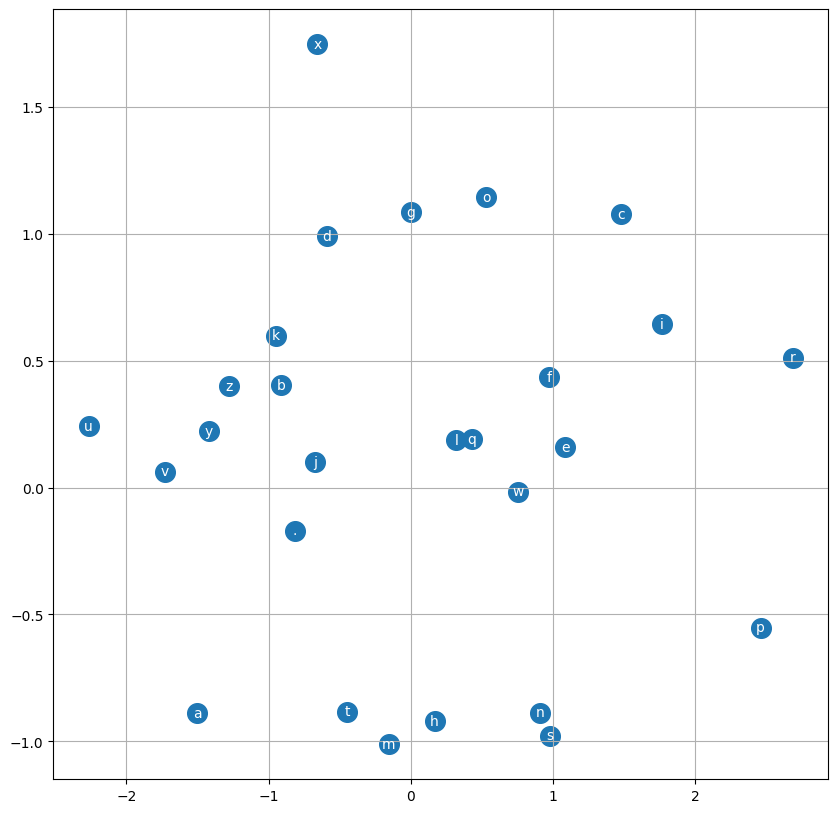

In [15]:
# Visualization of the embedding matrix
plt.figure(figsize=(10, 10))
plt.scatter(C[:,0].data, C[:,1].data, s=200)  # dimensions of 0 and 1
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), idx2str[i], ha="center", va="center", color='white')
plt.grid('minor')

### Inference

In [16]:
def generate_name():
    new_name = []
    context = [0] * MLPConfig.context_size
    
    while True:
        # forward pass
        x = torch.tensor(context)
        x_embed = C[x]
        x = x_embed.view(1, -1)
        h = F.tanh(x @ W1 + b1)
        logits = h @ W2 + b2
        
        # sample
        probs = F.softmax(logits, dim=-1)
        idx = torch.multinomial(probs, num_samples=1).item()
        
        # update context
        new_name.append(idx2str[idx])
        context = context[1:] + [idx]
        
        # break if "."
        if idx == 0:
            break
        
    return "".join(new_name)

In [17]:
for _ in range(5):
    print(generate_name())

ffokogxgxcxbcoaxg.
wnrufgnj.
qxidokigkcxzbrkfgacuhb.
qaudrovgqixouixhcbfzasrwkqib.
qnoegknrkfgacgabutgkdxbuigkcxzbpgbpkhxzaictfflkgickfutgkcxauixhcbfzasrwvfokgrrsfbkymo.
